## Importing libraries

In [65]:
# normal ds libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# metrics libraries
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Taking in data

In [66]:
train = pd.read_csv("/Users/orenj/Jupyter Notebooks/Data Quest 2023/DataQuest Dataset - train_data.csv") # change file directories
test = pd.read_csv(r"/Users/orenj/Jupyter Notebooks/Data Quest 2023/DataQuest Dataset - test_data.csv")

In [67]:
encoder = LabelEncoder()

# fit and transform the 'Meal Plan' column
encoded = encoder.fit_transform(train['MealPlan'])
encoded1 = encoder.fit_transform(train['RoomType'])
encoded2 = encoder.fit_transform(train['MarketSegment'])
encoded3 = encoder.fit_transform(train['BookingStatus'])

# replace the original 'Meal Plan' column with the encoded values
train['MealPlan'] = encoded
train['RoomType'] = encoded1
train['MarketSegment'] = encoded2
train['BookingStatus'] = encoded3

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [90]:
train['CancelRatio'] = train['NumPrevCancellations'] / (train['NumPreviousNonCancelled'] + train['NumPrevCancellations'])
train['CancelRatio'] = train['CancelRatio'].replace(np.nan, 0)
train['NumGuests'] = train['NumAdults'] + train['NumChildren']
train['Nights'] = train['NumWeekendNights'] + train['NumWeekNights']
train['totalPrice'] = train['Nights']*train['AvgRoomPrice']
train['Date'] = pd.to_datetime(train['ArrivalYear'].astype(str) + '-' + train['ArrivalMonth'].astype(str).str.zfill(2) + '-' + train['ArrivalDate'].astype(str).str.zfill(2), errors='coerce')
cat_features = ['MealPlan', 'Parking', 'RoomType', 'MarketSegment', 'RepeatedGuest']

# create the transformer for one-hot encoding
# calculate number of days since first date
train = train.sort_values(by='Date')
first_date = train['Date'].iloc[0]
train['DaysSinceFirst'] = (train['Date'] - first_date).dt.days


train.replace([np.inf, -np.inf], np.nan, inplace=True)
train=train.dropna()
x = train.loc[:, (train.columns != 'BookingStatus') & (train.columns != 'BookingID') & (train.columns != 'Date')]
y = train.BookingStatus # Target variable



In [91]:
#test train and x,y split
y = train['BookingStatus']
#x = train.drop(['BookingStatus', 'BookingID'], axis=1)
x = train.loc[:, (train.columns != 'BookingStatus') & (train.columns != 'BookingID') & (train.columns != 'Date') & (train.columns != 'ArrivalYear') & (train.columns != 'ArrivalMonth') & (train.columns != 'ArrivalDate') & (train.columns != 'Date')]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) #shuffles data (or orders it) so don't worry if it looks like a booking ID

CT = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_features)],remainder='passthrough')
x_train = CT.fit_transform(x_train)
x_test = CT.transform(x_test)

## Apply MLP Classifier model
Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data

In [92]:
# standardize data to (-1,+1) with mean 0 and variance 1
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
# apply same transformation to test data
x_test = scaler.transform(x_test)

In [138]:
# final model
mlp = MLPClassifier(activation='relu',max_iter=1000, alpha=0.05, hidden_layer_sizes=(100,100,100,100,100), learning_rate='constant', solver='adam', early_stopping=True)
mlp.fit(x_train, y_train)

MLPClassifier(alpha=0.05, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100, 100, 100), max_iter=1000)

In [139]:
y_pred = mlp.predict(x_test) # predict the test data

# find metrics
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred, average = "binary", pos_label=1)
recall_score(y_test, y_pred, pos_label=1)
f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8577670461078533
Recall: 0.9107692307692308
Precision: 0.8816812841303988
F1 Score: 0.8959892373665181


In [140]:
print (f'Train Accuracy: {mlp.score(x_train,y_train):.3f}')
print (f'Test Accuracy: {mlp.score(x_test,y_test):.3f}')

Train Accuracy: 0.879
Test Accuracy: 0.858


## Plotting the performance

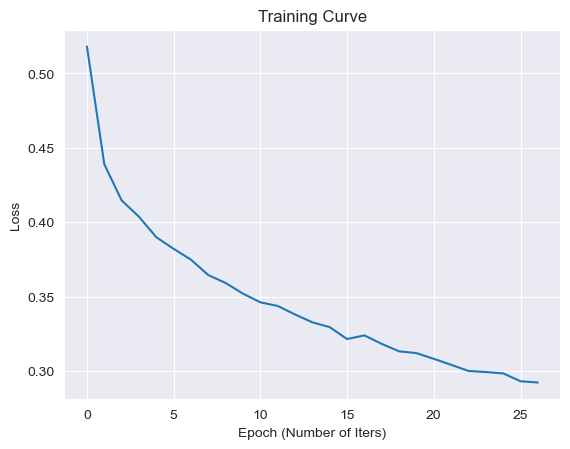

In [141]:
# Plot the training curve
# get the training error
#train_error = 1.0 - mlp.score(x_train, y_train)
plt.plot(mlp.loss_curve_)  # if we start getting an increase it means we are overfitting the data
#plt.plot(mlp.validation_scores_)
plt.title('Training Curve')
plt.xlabel('Epoch (Number of Iters)')
plt.ylabel('Loss')
plt.show()

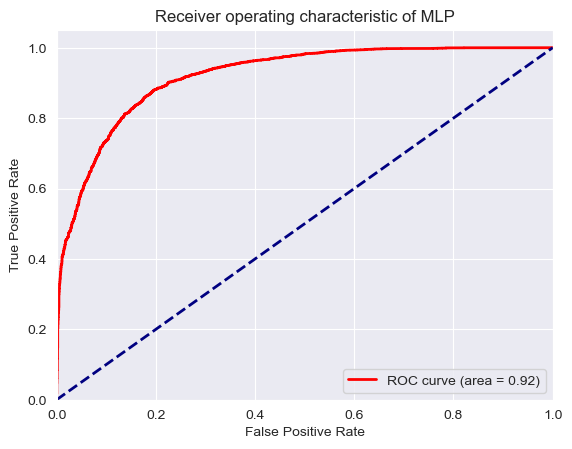

In [151]:
# ROC curve
# Get the predicted probabilities for each sample in the test set
y_score = mlp.predict_proba(x_test)[:,1]
# Compute the FPR, TPR, and threshold values for different probability cutoffs
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of MLP')
plt.legend(loc="lower right")
plt.show()